In [6]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# loading the xtc and gro file into mdtraj
traj = md.load('../../xtc_files/50000eql2.xtc', top='../../xtc_files/conf.gro')

In [8]:
# converting traj as traj with only 5000 frames
traj=traj[::2]

In [9]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in tqdm(range(nframes)):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

100%|██████████| 25001/25001 [01:02<00:00, 399.04it/s]


(25001, 592, 3)


In [10]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in tqdm(range(nframes)):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

100%|██████████| 25001/25001 [3:06:54<00:00,  2.23it/s]  

25001


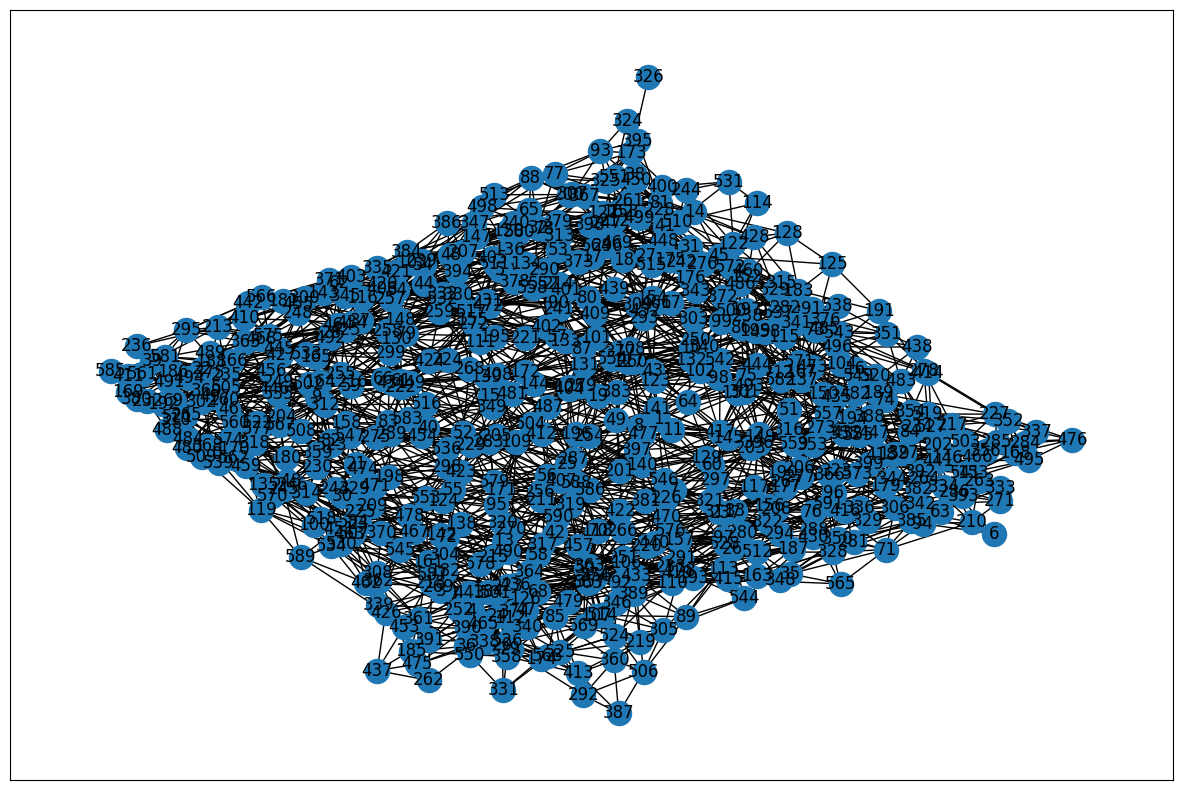

In [11]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [12]:
graphs = []
for frame in tqdm(range(nframes)):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

100%|██████████| 25001/25001 [00:01<00:00, 17678.15it/s]

Data(x=[592, 3], edge_index=[2, 8126], y=[1])


In [13]:
# import model.
from model import *

In [14]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
from pytorch3d.loss import chamfer_distance

In [16]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [17]:
#for data in train_loader_set:
#    z,encoded_edgeindex=model.encode(data.x,data.edge_index)
#    decodedx,decoded_edgeindex=model.decode(z,encoded_edgeindex)
#    # print(data)
#    print(decodedx)
#    print("data.x")
#    print(data.x)
#    print("sizes")
#    print(decodedx.size())
#    print(data.x.size())

In [18]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [19]:
# writing a vakidation function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [20]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    type_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index= model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss+closs 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        

    return loss_all / len(test_loader_set.dataset), closs_all/len(test_loader_set.dataset),feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [21]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []
val_total_losses = []
val_feature_losses = []
val_edge_losses = []
val_kl_losses = []
test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
cd_losses=[]
val_cd_losses=[]
test_cd_losses=[]
for epoch in tqdm(range(1, epochs+ 1)):
    total_loss, cd_loss,feature_loss, edge_loss, kl_loss = train()
    val_total_loss, val_cd_loss,val_feature_loss, val_edge_loss, val_kl_loss = validate()
    test_total_loss, test_cd_loss,test_feature_loss, test_edge_loss, test_kl_loss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'TRAIN : Total Loss: {total_loss:.4f}, CD Loss : {cd_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}')
    print(f'VALIDATE : Total Loss: {val_total_loss:.4f}, CD Loss : {val_cd_loss:.4f},Feature Loss: {val_feature_loss:.4f}, Edge Loss: {val_edge_loss:.4f}')
    print(f'TEST : Total Loss: {test_total_loss:.4f},CD Loss : {test_cd_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Edge Loss: {test_edge_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    val_total_losses.append(val_total_loss)
    val_feature_losses.append(val_feature_loss)
    val_edge_losses.append(val_edge_loss)
    val_kl_losses.append(val_kl_loss)
    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_edge_losses.append(test_edge_loss)
    test_kl_losses.append(test_kl_loss)
    cd_losses.append(cd_loss)
    val_cd_losses.append(val_cd_loss)   
    test_cd_losses.append(test_cd_loss) 
    

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_4442/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_4442/368484634.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_4442/3817500453.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
  1%|          | 1/100 [03:35<5:55:22, 215.38s/it]

Epoch: 001
TRAIN : Total Loss: 1.6881, CD Loss : 1.1579, Feature Loss: 0.5302, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.7727, CD Loss : 0.5429,Feature Loss: 0.2298, Edge Loss: 0.0000
TEST : Total Loss: 0.7733,CD Loss : 0.5436, Feature Loss: 0.2298, Edge Loss: 0.0000


  2%|▏         | 2/100 [07:08<5:49:48, 214.17s/it]

Epoch: 002
TRAIN : Total Loss: 0.6829, CD Loss : 0.4679, Feature Loss: 0.2150, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.5883, CD Loss : 0.3873,Feature Loss: 0.2010, Edge Loss: 0.0000
TEST : Total Loss: 0.5892,CD Loss : 0.3881, Feature Loss: 0.2011, Edge Loss: 0.0000


  3%|▎         | 3/100 [10:28<5:35:46, 207.70s/it]

Epoch: 003
TRAIN : Total Loss: 0.5211, CD Loss : 0.3345, Feature Loss: 0.1866, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4657, CD Loss : 0.2904,Feature Loss: 0.1754, Edge Loss: 0.0000
TEST : Total Loss: 0.4664,CD Loss : 0.2908, Feature Loss: 0.1757, Edge Loss: 0.0000


  4%|▍         | 4/100 [13:49<5:28:06, 205.07s/it]

Epoch: 004
TRAIN : Total Loss: 0.4328, CD Loss : 0.2621, Feature Loss: 0.1707, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4138, CD Loss : 0.2470,Feature Loss: 0.1668, Edge Loss: 0.0000
TEST : Total Loss: 0.4146,CD Loss : 0.2474, Feature Loss: 0.1672, Edge Loss: 0.0000


  5%|▌         | 5/100 [17:13<5:23:46, 204.49s/it]

Epoch: 005
TRAIN : Total Loss: 0.4000, CD Loss : 0.2380, Feature Loss: 0.1620, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3805, CD Loss : 0.2253,Feature Loss: 0.1552, Edge Loss: 0.0000
TEST : Total Loss: 0.3813,CD Loss : 0.2257, Feature Loss: 0.1556, Edge Loss: 0.0000


  6%|▌         | 6/100 [20:44<5:23:58, 206.79s/it]

Epoch: 006
TRAIN : Total Loss: 0.3545, CD Loss : 0.2071, Feature Loss: 0.1474, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3333, CD Loss : 0.1923,Feature Loss: 0.1410, Edge Loss: 0.0000
TEST : Total Loss: 0.3341,CD Loss : 0.1926, Feature Loss: 0.1415, Edge Loss: 0.0000


  7%|▋         | 7/100 [23:58<5:14:10, 202.70s/it]

Epoch: 007
TRAIN : Total Loss: 0.3205, CD Loss : 0.1839, Feature Loss: 0.1365, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3095, CD Loss : 0.1767,Feature Loss: 0.1327, Edge Loss: 0.0000
TEST : Total Loss: 0.3103,CD Loss : 0.1771, Feature Loss: 0.1332, Edge Loss: 0.0000


  8%|▊         | 8/100 [27:30<5:15:21, 205.67s/it]

Epoch: 008
TRAIN : Total Loss: 0.3020, CD Loss : 0.1722, Feature Loss: 0.1299, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2947, CD Loss : 0.1675,Feature Loss: 0.1271, Edge Loss: 0.0000
TEST : Total Loss: 0.2955,CD Loss : 0.1679, Feature Loss: 0.1276, Edge Loss: 0.0000


  9%|▉         | 9/100 [30:55<5:11:37, 205.47s/it]

Epoch: 009
TRAIN : Total Loss: 0.2899, CD Loss : 0.1658, Feature Loss: 0.1241, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2864, CD Loss : 0.1658,Feature Loss: 0.1207, Edge Loss: 0.0000
TEST : Total Loss: 0.2870,CD Loss : 0.1661, Feature Loss: 0.1209, Edge Loss: 0.0000


 10%|█         | 10/100 [34:11<5:03:42, 202.47s/it]

Epoch: 010
TRAIN : Total Loss: 0.2842, CD Loss : 0.1667, Feature Loss: 0.1175, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2816, CD Loss : 0.1669,Feature Loss: 0.1147, Edge Loss: 0.0000
TEST : Total Loss: 0.2818,CD Loss : 0.1671, Feature Loss: 0.1147, Edge Loss: 0.0000


 11%|█         | 11/100 [37:32<4:59:33, 201.95s/it]

Epoch: 011
TRAIN : Total Loss: 0.2789, CD Loss : 0.1666, Feature Loss: 0.1123, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2766, CD Loss : 0.1661,Feature Loss: 0.1105, Edge Loss: 0.0000
TEST : Total Loss: 0.2766,CD Loss : 0.1662, Feature Loss: 0.1104, Edge Loss: 0.0000


 12%|█▏        | 12/100 [40:56<4:57:21, 202.74s/it]

Epoch: 012
TRAIN : Total Loss: 0.2743, CD Loss : 0.1653, Feature Loss: 0.1091, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2722, CD Loss : 0.1641,Feature Loss: 0.1082, Edge Loss: 0.0000
TEST : Total Loss: 0.2721,CD Loss : 0.1641, Feature Loss: 0.1080, Edge Loss: 0.0000


 13%|█▎        | 13/100 [44:17<4:53:06, 202.15s/it]

Epoch: 013
TRAIN : Total Loss: 0.2708, CD Loss : 0.1634, Feature Loss: 0.1074, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2696, CD Loss : 0.1628,Feature Loss: 0.1068, Edge Loss: 0.0000
TEST : Total Loss: 0.2695,CD Loss : 0.1629, Feature Loss: 0.1066, Edge Loss: 0.0000


 14%|█▍        | 14/100 [47:29<4:45:16, 199.03s/it]

Epoch: 014
TRAIN : Total Loss: 0.2679, CD Loss : 0.1617, Feature Loss: 0.1062, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2669, CD Loss : 0.1610,Feature Loss: 0.1059, Edge Loss: 0.0000
TEST : Total Loss: 0.2667,CD Loss : 0.1611, Feature Loss: 0.1057, Edge Loss: 0.0000


 15%|█▌        | 15/100 [50:33<4:35:44, 194.65s/it]

Epoch: 015
TRAIN : Total Loss: 0.2656, CD Loss : 0.1603, Feature Loss: 0.1053, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2648, CD Loss : 0.1597,Feature Loss: 0.1051, Edge Loss: 0.0000
TEST : Total Loss: 0.2646,CD Loss : 0.1597, Feature Loss: 0.1049, Edge Loss: 0.0000


 16%|█▌        | 16/100 [54:22<4:46:43, 204.81s/it]

Epoch: 016
TRAIN : Total Loss: 0.2637, CD Loss : 0.1591, Feature Loss: 0.1046, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2629, CD Loss : 0.1585,Feature Loss: 0.1044, Edge Loss: 0.0000
TEST : Total Loss: 0.2628,CD Loss : 0.1586, Feature Loss: 0.1042, Edge Loss: 0.0000


 17%|█▋        | 17/100 [57:41<4:40:52, 203.05s/it]

Epoch: 017
TRAIN : Total Loss: 0.2623, CD Loss : 0.1584, Feature Loss: 0.1040, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2620, CD Loss : 0.1582,Feature Loss: 0.1038, Edge Loss: 0.0000
TEST : Total Loss: 0.2619,CD Loss : 0.1583, Feature Loss: 0.1036, Edge Loss: 0.0000


 18%|█▊        | 18/100 [1:01:04<4:37:40, 203.18s/it]

Epoch: 018
TRAIN : Total Loss: 0.2611, CD Loss : 0.1578, Feature Loss: 0.1034, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2601, CD Loss : 0.1569,Feature Loss: 0.1032, Edge Loss: 0.0000
TEST : Total Loss: 0.2599,CD Loss : 0.1570, Feature Loss: 0.1030, Edge Loss: 0.0000


 19%|█▉        | 19/100 [1:04:19<4:30:50, 200.62s/it]

Epoch: 019
TRAIN : Total Loss: 0.2602, CD Loss : 0.1574, Feature Loss: 0.1028, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2602, CD Loss : 0.1575,Feature Loss: 0.1026, Edge Loss: 0.0000
TEST : Total Loss: 0.2601,CD Loss : 0.1576, Feature Loss: 0.1024, Edge Loss: 0.0000


 20%|██        | 20/100 [1:07:30<4:23:37, 197.72s/it]

Epoch: 020
TRAIN : Total Loss: 0.2594, CD Loss : 0.1571, Feature Loss: 0.1023, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2590, CD Loss : 0.1568,Feature Loss: 0.1021, Edge Loss: 0.0000
TEST : Total Loss: 0.2588,CD Loss : 0.1569, Feature Loss: 0.1019, Edge Loss: 0.0000


 21%|██        | 21/100 [1:10:37<4:16:08, 194.54s/it]

Epoch: 021
TRAIN : Total Loss: 0.2587, CD Loss : 0.1570, Feature Loss: 0.1018, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2589, CD Loss : 0.1572,Feature Loss: 0.1017, Edge Loss: 0.0000
TEST : Total Loss: 0.2587,CD Loss : 0.1573, Feature Loss: 0.1015, Edge Loss: 0.0000


 22%|██▏       | 22/100 [1:13:42<4:09:09, 191.66s/it]

Epoch: 022
TRAIN : Total Loss: 0.2581, CD Loss : 0.1568, Feature Loss: 0.1013, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2582, CD Loss : 0.1570,Feature Loss: 0.1012, Edge Loss: 0.0000
TEST : Total Loss: 0.2581,CD Loss : 0.1571, Feature Loss: 0.1010, Edge Loss: 0.0000


 23%|██▎       | 23/100 [1:17:20<4:16:08, 199.59s/it]

Epoch: 023
TRAIN : Total Loss: 0.2576, CD Loss : 0.1567, Feature Loss: 0.1009, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2574, CD Loss : 0.1566,Feature Loss: 0.1008, Edge Loss: 0.0000
TEST : Total Loss: 0.2572,CD Loss : 0.1566, Feature Loss: 0.1006, Edge Loss: 0.0000


 24%|██▍       | 24/100 [1:20:34<4:10:36, 197.84s/it]

Epoch: 024
TRAIN : Total Loss: 0.2570, CD Loss : 0.1566, Feature Loss: 0.1005, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2572, CD Loss : 0.1568,Feature Loss: 0.1004, Edge Loss: 0.0000
TEST : Total Loss: 0.2570,CD Loss : 0.1568, Feature Loss: 0.1002, Edge Loss: 0.0000


 25%|██▌       | 25/100 [1:23:56<4:09:05, 199.27s/it]

Epoch: 025
TRAIN : Total Loss: 0.2565, CD Loss : 0.1564, Feature Loss: 0.1001, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2560, CD Loss : 0.1560,Feature Loss: 0.1000, Edge Loss: 0.0000
TEST : Total Loss: 0.2559,CD Loss : 0.1560, Feature Loss: 0.0999, Edge Loss: 0.0000


 26%|██▌       | 26/100 [1:27:11<4:03:51, 197.73s/it]

Epoch: 026
TRAIN : Total Loss: 0.2560, CD Loss : 0.1563, Feature Loss: 0.0997, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2558, CD Loss : 0.1562,Feature Loss: 0.0996, Edge Loss: 0.0000
TEST : Total Loss: 0.2557,CD Loss : 0.1562, Feature Loss: 0.0995, Edge Loss: 0.0000


 27%|██▋       | 27/100 [1:30:16<3:56:11, 194.13s/it]

Epoch: 027
TRAIN : Total Loss: 0.2556, CD Loss : 0.1562, Feature Loss: 0.0994, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2556, CD Loss : 0.1562,Feature Loss: 0.0993, Edge Loss: 0.0000
TEST : Total Loss: 0.2554,CD Loss : 0.1563, Feature Loss: 0.0991, Edge Loss: 0.0000


 28%|██▊       | 28/100 [1:33:43<3:57:32, 197.96s/it]

Epoch: 028
TRAIN : Total Loss: 0.2552, CD Loss : 0.1561, Feature Loss: 0.0990, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2550, CD Loss : 0.1559,Feature Loss: 0.0990, Edge Loss: 0.0000
TEST : Total Loss: 0.2548,CD Loss : 0.1559, Feature Loss: 0.0989, Edge Loss: 0.0000


 29%|██▉       | 29/100 [1:36:38<3:46:01, 191.01s/it]

Epoch: 029
TRAIN : Total Loss: 0.2549, CD Loss : 0.1561, Feature Loss: 0.0988, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2549, CD Loss : 0.1561,Feature Loss: 0.0988, Edge Loss: 0.0000
TEST : Total Loss: 0.2547,CD Loss : 0.1561, Feature Loss: 0.0986, Edge Loss: 0.0000


 30%|███       | 30/100 [1:39:51<3:43:37, 191.67s/it]

Epoch: 030
TRAIN : Total Loss: 0.2546, CD Loss : 0.1561, Feature Loss: 0.0985, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2549, CD Loss : 0.1564,Feature Loss: 0.0985, Edge Loss: 0.0000
TEST : Total Loss: 0.2547,CD Loss : 0.1564, Feature Loss: 0.0983, Edge Loss: 0.0000


 31%|███       | 31/100 [1:43:15<3:44:35, 195.30s/it]

Epoch: 031
TRAIN : Total Loss: 0.2544, CD Loss : 0.1561, Feature Loss: 0.0982, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2543, CD Loss : 0.1561,Feature Loss: 0.0982, Edge Loss: 0.0000
TEST : Total Loss: 0.2542,CD Loss : 0.1562, Feature Loss: 0.0980, Edge Loss: 0.0000


 32%|███▏      | 32/100 [1:46:51<3:48:13, 201.37s/it]

Epoch: 032
TRAIN : Total Loss: 0.2542, CD Loss : 0.1563, Feature Loss: 0.0980, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2547, CD Loss : 0.1568,Feature Loss: 0.0980, Edge Loss: 0.0000
TEST : Total Loss: 0.2546,CD Loss : 0.1568, Feature Loss: 0.0978, Edge Loss: 0.0000


 33%|███▎      | 33/100 [1:50:32<3:51:27, 207.28s/it]

Epoch: 033
TRAIN : Total Loss: 0.2541, CD Loss : 0.1564, Feature Loss: 0.0977, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2542, CD Loss : 0.1565,Feature Loss: 0.0977, Edge Loss: 0.0000
TEST : Total Loss: 0.2541,CD Loss : 0.1565, Feature Loss: 0.0975, Edge Loss: 0.0000


 34%|███▍      | 34/100 [1:53:44<3:43:00, 202.73s/it]

Epoch: 034
TRAIN : Total Loss: 0.2541, CD Loss : 0.1567, Feature Loss: 0.0975, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2544, CD Loss : 0.1569,Feature Loss: 0.0974, Edge Loss: 0.0000
TEST : Total Loss: 0.2543,CD Loss : 0.1570, Feature Loss: 0.0973, Edge Loss: 0.0000


 35%|███▌      | 35/100 [1:57:08<3:40:10, 203.24s/it]

Epoch: 035
TRAIN : Total Loss: 0.2541, CD Loss : 0.1569, Feature Loss: 0.0972, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2539, CD Loss : 0.1567,Feature Loss: 0.0972, Edge Loss: 0.0000
TEST : Total Loss: 0.2538,CD Loss : 0.1568, Feature Loss: 0.0970, Edge Loss: 0.0000


 36%|███▌      | 36/100 [2:00:29<3:35:59, 202.49s/it]

Epoch: 036
TRAIN : Total Loss: 0.2542, CD Loss : 0.1573, Feature Loss: 0.0969, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2538, CD Loss : 0.1569,Feature Loss: 0.0969, Edge Loss: 0.0000
TEST : Total Loss: 0.2537,CD Loss : 0.1570, Feature Loss: 0.0968, Edge Loss: 0.0000


 37%|███▋      | 37/100 [2:03:33<3:26:43, 196.89s/it]

Epoch: 037
TRAIN : Total Loss: 0.2543, CD Loss : 0.1577, Feature Loss: 0.0966, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2547, CD Loss : 0.1581,Feature Loss: 0.0966, Edge Loss: 0.0000
TEST : Total Loss: 0.2546,CD Loss : 0.1581, Feature Loss: 0.0965, Edge Loss: 0.0000


 38%|███▊      | 38/100 [2:06:31<3:17:33, 191.18s/it]

Epoch: 038
TRAIN : Total Loss: 0.2544, CD Loss : 0.1581, Feature Loss: 0.0963, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2550, CD Loss : 0.1588,Feature Loss: 0.0962, Edge Loss: 0.0000
TEST : Total Loss: 0.2549,CD Loss : 0.1589, Feature Loss: 0.0960, Edge Loss: 0.0000


 39%|███▉      | 39/100 [2:09:31<3:11:10, 188.04s/it]

Epoch: 039
TRAIN : Total Loss: 0.2543, CD Loss : 0.1584, Feature Loss: 0.0959, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2545, CD Loss : 0.1587,Feature Loss: 0.0958, Edge Loss: 0.0000
TEST : Total Loss: 0.2544,CD Loss : 0.1588, Feature Loss: 0.0956, Edge Loss: 0.0000


 40%|████      | 40/100 [2:13:02<3:14:53, 194.90s/it]

Epoch: 040
TRAIN : Total Loss: 0.2539, CD Loss : 0.1583, Feature Loss: 0.0956, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2536, CD Loss : 0.1580,Feature Loss: 0.0955, Edge Loss: 0.0000
TEST : Total Loss: 0.2534,CD Loss : 0.1580, Feature Loss: 0.0954, Edge Loss: 0.0000


 41%|████      | 41/100 [2:16:33<3:16:13, 199.55s/it]

Epoch: 041
TRAIN : Total Loss: 0.2534, CD Loss : 0.1581, Feature Loss: 0.0953, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2529, CD Loss : 0.1577,Feature Loss: 0.0952, Edge Loss: 0.0000
TEST : Total Loss: 0.2528,CD Loss : 0.1577, Feature Loss: 0.0951, Edge Loss: 0.0000


 42%|████▏     | 42/100 [2:19:22<3:04:14, 190.59s/it]

Epoch: 042
TRAIN : Total Loss: 0.2529, CD Loss : 0.1578, Feature Loss: 0.0951, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2530, CD Loss : 0.1579,Feature Loss: 0.0951, Edge Loss: 0.0000
TEST : Total Loss: 0.2528,CD Loss : 0.1579, Feature Loss: 0.0949, Edge Loss: 0.0000


 43%|████▎     | 43/100 [2:23:01<3:09:11, 199.15s/it]

Epoch: 043
TRAIN : Total Loss: 0.2523, CD Loss : 0.1574, Feature Loss: 0.0949, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2521, CD Loss : 0.1572,Feature Loss: 0.0948, Edge Loss: 0.0000
TEST : Total Loss: 0.2519,CD Loss : 0.1572, Feature Loss: 0.0947, Edge Loss: 0.0000


 44%|████▍     | 44/100 [2:26:42<3:12:00, 205.72s/it]

Epoch: 044
TRAIN : Total Loss: 0.2519, CD Loss : 0.1571, Feature Loss: 0.0948, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2516, CD Loss : 0.1569,Feature Loss: 0.0947, Edge Loss: 0.0000
TEST : Total Loss: 0.2514,CD Loss : 0.1569, Feature Loss: 0.0946, Edge Loss: 0.0000


 45%|████▌     | 45/100 [2:30:21<3:12:14, 209.71s/it]

Epoch: 045
TRAIN : Total Loss: 0.2514, CD Loss : 0.1568, Feature Loss: 0.0946, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2515, CD Loss : 0.1568,Feature Loss: 0.0946, Edge Loss: 0.0000
TEST : Total Loss: 0.2513,CD Loss : 0.1568, Feature Loss: 0.0945, Edge Loss: 0.0000


 46%|████▌     | 46/100 [2:34:09<3:13:40, 215.20s/it]

Epoch: 046
TRAIN : Total Loss: 0.2509, CD Loss : 0.1564, Feature Loss: 0.0945, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2511, CD Loss : 0.1567,Feature Loss: 0.0945, Edge Loss: 0.0000
TEST : Total Loss: 0.2510,CD Loss : 0.1567, Feature Loss: 0.0943, Edge Loss: 0.0000


 47%|████▋     | 47/100 [2:37:36<3:07:55, 212.74s/it]

Epoch: 047
TRAIN : Total Loss: 0.2505, CD Loss : 0.1562, Feature Loss: 0.0944, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2503, CD Loss : 0.1559,Feature Loss: 0.0944, Edge Loss: 0.0000
TEST : Total Loss: 0.2501,CD Loss : 0.1559, Feature Loss: 0.0942, Edge Loss: 0.0000


 48%|████▊     | 48/100 [2:40:44<2:57:56, 205.33s/it]

Epoch: 048
TRAIN : Total Loss: 0.2501, CD Loss : 0.1559, Feature Loss: 0.0943, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2508, CD Loss : 0.1564,Feature Loss: 0.0944, Edge Loss: 0.0000
TEST : Total Loss: 0.2506,CD Loss : 0.1564, Feature Loss: 0.0942, Edge Loss: 0.0000


 49%|████▉     | 49/100 [2:43:45<2:48:15, 197.96s/it]

Epoch: 049
TRAIN : Total Loss: 0.2498, CD Loss : 0.1556, Feature Loss: 0.0942, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2496, CD Loss : 0.1555,Feature Loss: 0.0942, Edge Loss: 0.0000
TEST : Total Loss: 0.2495,CD Loss : 0.1555, Feature Loss: 0.0940, Edge Loss: 0.0000


 50%|█████     | 50/100 [2:46:52<2:42:08, 194.58s/it]

Epoch: 050
TRAIN : Total Loss: 0.2494, CD Loss : 0.1554, Feature Loss: 0.0941, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2492, CD Loss : 0.1551,Feature Loss: 0.0941, Edge Loss: 0.0000
TEST : Total Loss: 0.2490,CD Loss : 0.1551, Feature Loss: 0.0939, Edge Loss: 0.0000


 51%|█████     | 51/100 [2:50:05<2:38:26, 194.01s/it]

Epoch: 051
TRAIN : Total Loss: 0.2491, CD Loss : 0.1551, Feature Loss: 0.0940, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2491, CD Loss : 0.1551,Feature Loss: 0.0941, Edge Loss: 0.0000
TEST : Total Loss: 0.2490,CD Loss : 0.1551, Feature Loss: 0.0939, Edge Loss: 0.0000


 52%|█████▏    | 52/100 [2:53:17<2:34:41, 193.37s/it]

Epoch: 052
TRAIN : Total Loss: 0.2488, CD Loss : 0.1549, Feature Loss: 0.0939, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2485, CD Loss : 0.1546,Feature Loss: 0.0939, Edge Loss: 0.0000
TEST : Total Loss: 0.2483,CD Loss : 0.1546, Feature Loss: 0.0938, Edge Loss: 0.0000


 53%|█████▎    | 53/100 [2:56:29<2:31:20, 193.20s/it]

Epoch: 053
TRAIN : Total Loss: 0.2486, CD Loss : 0.1548, Feature Loss: 0.0938, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2488, CD Loss : 0.1549,Feature Loss: 0.0938, Edge Loss: 0.0000
TEST : Total Loss: 0.2486,CD Loss : 0.1549, Feature Loss: 0.0937, Edge Loss: 0.0000


 54%|█████▍    | 54/100 [3:00:20<2:36:38, 204.32s/it]

Epoch: 054
TRAIN : Total Loss: 0.2483, CD Loss : 0.1546, Feature Loss: 0.0937, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2484, CD Loss : 0.1547,Feature Loss: 0.0937, Edge Loss: 0.0000
TEST : Total Loss: 0.2483,CD Loss : 0.1547, Feature Loss: 0.0936, Edge Loss: 0.0000


 55%|█████▌    | 55/100 [3:03:41<2:32:34, 203.44s/it]

Epoch: 055
TRAIN : Total Loss: 0.2480, CD Loss : 0.1544, Feature Loss: 0.0936, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2487, CD Loss : 0.1550,Feature Loss: 0.0936, Edge Loss: 0.0000
TEST : Total Loss: 0.2485,CD Loss : 0.1551, Feature Loss: 0.0934, Edge Loss: 0.0000


 56%|█████▌    | 56/100 [3:06:47<2:25:15, 198.08s/it]

Epoch: 056
TRAIN : Total Loss: 0.2478, CD Loss : 0.1543, Feature Loss: 0.0935, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2477, CD Loss : 0.1542,Feature Loss: 0.0935, Edge Loss: 0.0000
TEST : Total Loss: 0.2476,CD Loss : 0.1542, Feature Loss: 0.0934, Edge Loss: 0.0000


 57%|█████▋    | 57/100 [3:09:42<2:17:10, 191.41s/it]

Epoch: 057
TRAIN : Total Loss: 0.2476, CD Loss : 0.1541, Feature Loss: 0.0935, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2471, CD Loss : 0.1535,Feature Loss: 0.0935, Edge Loss: 0.0000
TEST : Total Loss: 0.2469,CD Loss : 0.1536, Feature Loss: 0.0934, Edge Loss: 0.0000


 58%|█████▊    | 58/100 [3:12:45<2:12:04, 188.68s/it]

Epoch: 058
TRAIN : Total Loss: 0.2474, CD Loss : 0.1540, Feature Loss: 0.0934, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2472, CD Loss : 0.1538,Feature Loss: 0.0934, Edge Loss: 0.0000
TEST : Total Loss: 0.2471,CD Loss : 0.1539, Feature Loss: 0.0932, Edge Loss: 0.0000


 59%|█████▉    | 59/100 [3:15:50<2:08:12, 187.63s/it]

Epoch: 059
TRAIN : Total Loss: 0.2471, CD Loss : 0.1539, Feature Loss: 0.0933, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2474, CD Loss : 0.1542,Feature Loss: 0.0932, Edge Loss: 0.0000
TEST : Total Loss: 0.2474,CD Loss : 0.1543, Feature Loss: 0.0931, Edge Loss: 0.0000


 60%|██████    | 60/100 [3:19:21<2:09:52, 194.81s/it]

Epoch: 060
TRAIN : Total Loss: 0.2469, CD Loss : 0.1538, Feature Loss: 0.0931, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2469, CD Loss : 0.1538,Feature Loss: 0.0931, Edge Loss: 0.0000
TEST : Total Loss: 0.2470,CD Loss : 0.1540, Feature Loss: 0.0930, Edge Loss: 0.0000


 61%|██████    | 61/100 [3:22:32<2:05:44, 193.44s/it]

Epoch: 061
TRAIN : Total Loss: 0.2465, CD Loss : 0.1536, Feature Loss: 0.0929, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2463, CD Loss : 0.1534,Feature Loss: 0.0929, Edge Loss: 0.0000
TEST : Total Loss: 0.2465,CD Loss : 0.1536, Feature Loss: 0.0929, Edge Loss: 0.0000


 62%|██████▏   | 62/100 [3:25:38<2:01:09, 191.29s/it]

Epoch: 062
TRAIN : Total Loss: 0.2461, CD Loss : 0.1533, Feature Loss: 0.0928, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2459, CD Loss : 0.1530,Feature Loss: 0.0929, Edge Loss: 0.0000
TEST : Total Loss: 0.2460,CD Loss : 0.1532, Feature Loss: 0.0928, Edge Loss: 0.0000


 63%|██████▎   | 63/100 [3:29:37<2:06:52, 205.75s/it]

Epoch: 063
TRAIN : Total Loss: 0.2457, CD Loss : 0.1530, Feature Loss: 0.0927, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2449, CD Loss : 0.1520,Feature Loss: 0.0928, Edge Loss: 0.0000
TEST : Total Loss: 0.2450,CD Loss : 0.1522, Feature Loss: 0.0927, Edge Loss: 0.0000


 64%|██████▍   | 64/100 [3:32:37<1:58:47, 198.00s/it]

Epoch: 064
TRAIN : Total Loss: 0.2453, CD Loss : 0.1527, Feature Loss: 0.0926, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2455, CD Loss : 0.1529,Feature Loss: 0.0926, Edge Loss: 0.0000
TEST : Total Loss: 0.2455,CD Loss : 0.1531, Feature Loss: 0.0925, Edge Loss: 0.0000


 65%|██████▌   | 65/100 [3:36:07<1:57:30, 201.44s/it]

Epoch: 065
TRAIN : Total Loss: 0.2449, CD Loss : 0.1524, Feature Loss: 0.0925, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2455, CD Loss : 0.1529,Feature Loss: 0.0926, Edge Loss: 0.0000
TEST : Total Loss: 0.2455,CD Loss : 0.1531, Feature Loss: 0.0924, Edge Loss: 0.0000


 66%|██████▌   | 66/100 [3:39:44<1:56:47, 206.10s/it]

Epoch: 066
TRAIN : Total Loss: 0.2445, CD Loss : 0.1521, Feature Loss: 0.0924, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2449, CD Loss : 0.1523,Feature Loss: 0.0926, Edge Loss: 0.0000
TEST : Total Loss: 0.2449,CD Loss : 0.1525, Feature Loss: 0.0924, Edge Loss: 0.0000


 67%|██████▋   | 67/100 [3:42:52<1:50:21, 200.64s/it]

Epoch: 067
TRAIN : Total Loss: 0.2441, CD Loss : 0.1518, Feature Loss: 0.0923, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2442, CD Loss : 0.1517,Feature Loss: 0.0925, Edge Loss: 0.0000
TEST : Total Loss: 0.2442,CD Loss : 0.1519, Feature Loss: 0.0923, Edge Loss: 0.0000


 68%|██████▊   | 68/100 [3:46:00<1:45:04, 197.03s/it]

Epoch: 068
TRAIN : Total Loss: 0.2438, CD Loss : 0.1516, Feature Loss: 0.0922, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2431, CD Loss : 0.1508,Feature Loss: 0.0924, Edge Loss: 0.0000
TEST : Total Loss: 0.2431,CD Loss : 0.1509, Feature Loss: 0.0922, Edge Loss: 0.0000


 69%|██████▉   | 69/100 [3:49:24<1:42:50, 199.05s/it]

Epoch: 069
TRAIN : Total Loss: 0.2435, CD Loss : 0.1514, Feature Loss: 0.0922, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2442, CD Loss : 0.1519,Feature Loss: 0.0923, Edge Loss: 0.0000
TEST : Total Loss: 0.2442,CD Loss : 0.1521, Feature Loss: 0.0921, Edge Loss: 0.0000


 70%|███████   | 70/100 [3:52:35<1:38:19, 196.65s/it]

Epoch: 070
TRAIN : Total Loss: 0.2432, CD Loss : 0.1511, Feature Loss: 0.0921, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2434, CD Loss : 0.1512,Feature Loss: 0.0922, Edge Loss: 0.0000
TEST : Total Loss: 0.2433,CD Loss : 0.1513, Feature Loss: 0.0920, Edge Loss: 0.0000


 71%|███████   | 71/100 [3:55:41<1:33:32, 193.54s/it]

Epoch: 071
TRAIN : Total Loss: 0.2429, CD Loss : 0.1509, Feature Loss: 0.0920, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2427, CD Loss : 0.1506,Feature Loss: 0.0922, Edge Loss: 0.0000
TEST : Total Loss: 0.2427,CD Loss : 0.1507, Feature Loss: 0.0919, Edge Loss: 0.0000


 72%|███████▏  | 72/100 [3:58:57<1:30:34, 194.08s/it]

Epoch: 072
TRAIN : Total Loss: 0.2427, CD Loss : 0.1507, Feature Loss: 0.0920, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2428, CD Loss : 0.1506,Feature Loss: 0.0921, Edge Loss: 0.0000
TEST : Total Loss: 0.2426,CD Loss : 0.1508, Feature Loss: 0.0919, Edge Loss: 0.0000


 73%|███████▎  | 73/100 [4:02:31<1:30:01, 200.06s/it]

Epoch: 073
TRAIN : Total Loss: 0.2424, CD Loss : 0.1505, Feature Loss: 0.0919, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2428, CD Loss : 0.1508,Feature Loss: 0.0920, Edge Loss: 0.0000
TEST : Total Loss: 0.2426,CD Loss : 0.1509, Feature Loss: 0.0918, Edge Loss: 0.0000


 74%|███████▍  | 74/100 [4:05:48<1:26:18, 199.16s/it]

Epoch: 074
TRAIN : Total Loss: 0.2421, CD Loss : 0.1503, Feature Loss: 0.0918, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2424, CD Loss : 0.1504,Feature Loss: 0.0920, Edge Loss: 0.0000
TEST : Total Loss: 0.2422,CD Loss : 0.1505, Feature Loss: 0.0917, Edge Loss: 0.0000


 75%|███████▌  | 75/100 [4:09:00<1:22:06, 197.07s/it]

Epoch: 075
TRAIN : Total Loss: 0.2419, CD Loss : 0.1501, Feature Loss: 0.0918, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2432, CD Loss : 0.1512,Feature Loss: 0.0920, Edge Loss: 0.0000
TEST : Total Loss: 0.2430,CD Loss : 0.1512, Feature Loss: 0.0917, Edge Loss: 0.0000


 76%|███████▌  | 76/100 [4:12:18<1:18:57, 197.39s/it]

Epoch: 076
TRAIN : Total Loss: 0.2416, CD Loss : 0.1499, Feature Loss: 0.0917, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2426, CD Loss : 0.1506,Feature Loss: 0.0920, Edge Loss: 0.0000
TEST : Total Loss: 0.2424,CD Loss : 0.1507, Feature Loss: 0.0917, Edge Loss: 0.0000


 77%|███████▋  | 77/100 [4:15:51<1:17:28, 202.11s/it]

Epoch: 077
TRAIN : Total Loss: 0.2414, CD Loss : 0.1497, Feature Loss: 0.0917, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2417, CD Loss : 0.1499,Feature Loss: 0.0918, Edge Loss: 0.0000
TEST : Total Loss: 0.2415,CD Loss : 0.1500, Feature Loss: 0.0916, Edge Loss: 0.0000


 78%|███████▊  | 78/100 [4:19:06<1:13:15, 199.79s/it]

Epoch: 078
TRAIN : Total Loss: 0.2411, CD Loss : 0.1495, Feature Loss: 0.0916, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2416, CD Loss : 0.1497,Feature Loss: 0.0919, Edge Loss: 0.0000
TEST : Total Loss: 0.2414,CD Loss : 0.1498, Feature Loss: 0.0916, Edge Loss: 0.0000


 79%|███████▉  | 79/100 [4:22:08<1:08:05, 194.53s/it]

Epoch: 079
TRAIN : Total Loss: 0.2409, CD Loss : 0.1493, Feature Loss: 0.0916, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2411, CD Loss : 0.1495,Feature Loss: 0.0917, Edge Loss: 0.0000
TEST : Total Loss: 0.2409,CD Loss : 0.1495, Feature Loss: 0.0914, Edge Loss: 0.0000


 80%|████████  | 80/100 [4:25:39<1:06:29, 199.47s/it]

Epoch: 080
TRAIN : Total Loss: 0.2406, CD Loss : 0.1491, Feature Loss: 0.0915, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2411, CD Loss : 0.1493,Feature Loss: 0.0917, Edge Loss: 0.0000
TEST : Total Loss: 0.2408,CD Loss : 0.1494, Feature Loss: 0.0915, Edge Loss: 0.0000


 81%|████████  | 81/100 [4:28:50<1:02:22, 196.96s/it]

Epoch: 081
TRAIN : Total Loss: 0.2403, CD Loss : 0.1489, Feature Loss: 0.0915, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2406, CD Loss : 0.1489,Feature Loss: 0.0917, Edge Loss: 0.0000
TEST : Total Loss: 0.2404,CD Loss : 0.1490, Feature Loss: 0.0914, Edge Loss: 0.0000


 82%|████████▏ | 82/100 [4:32:08<59:10, 197.23s/it]  

Epoch: 082
TRAIN : Total Loss: 0.2401, CD Loss : 0.1487, Feature Loss: 0.0914, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2404, CD Loss : 0.1488,Feature Loss: 0.0916, Edge Loss: 0.0000
TEST : Total Loss: 0.2402,CD Loss : 0.1489, Feature Loss: 0.0913, Edge Loss: 0.0000


 83%|████████▎ | 83/100 [4:35:22<55:34, 196.17s/it]

Epoch: 083
TRAIN : Total Loss: 0.2398, CD Loss : 0.1484, Feature Loss: 0.0914, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2399, CD Loss : 0.1483,Feature Loss: 0.0916, Edge Loss: 0.0000
TEST : Total Loss: 0.2396,CD Loss : 0.1483, Feature Loss: 0.0913, Edge Loss: 0.0000


 84%|████████▍ | 84/100 [4:38:53<53:32, 200.78s/it]

Epoch: 084
TRAIN : Total Loss: 0.2395, CD Loss : 0.1482, Feature Loss: 0.0913, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2405, CD Loss : 0.1490,Feature Loss: 0.0915, Edge Loss: 0.0000
TEST : Total Loss: 0.2402,CD Loss : 0.1490, Feature Loss: 0.0912, Edge Loss: 0.0000


 85%|████████▌ | 85/100 [4:42:14<50:14, 200.94s/it]

Epoch: 085
TRAIN : Total Loss: 0.2393, CD Loss : 0.1480, Feature Loss: 0.0913, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2393, CD Loss : 0.1478,Feature Loss: 0.0914, Edge Loss: 0.0000
TEST : Total Loss: 0.2390,CD Loss : 0.1479, Feature Loss: 0.0911, Edge Loss: 0.0000


 86%|████████▌ | 86/100 [4:45:37<46:58, 201.35s/it]

Epoch: 086
TRAIN : Total Loss: 0.2390, CD Loss : 0.1478, Feature Loss: 0.0912, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2400, CD Loss : 0.1485,Feature Loss: 0.0915, Edge Loss: 0.0000
TEST : Total Loss: 0.2398,CD Loss : 0.1485, Feature Loss: 0.0913, Edge Loss: 0.0000


 87%|████████▋ | 87/100 [4:48:58<43:36, 201.30s/it]

Epoch: 087
TRAIN : Total Loss: 0.2387, CD Loss : 0.1475, Feature Loss: 0.0912, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2388, CD Loss : 0.1475,Feature Loss: 0.0913, Edge Loss: 0.0000
TEST : Total Loss: 0.2385,CD Loss : 0.1475, Feature Loss: 0.0910, Edge Loss: 0.0000


 88%|████████▊ | 88/100 [4:52:44<41:43, 208.64s/it]

Epoch: 088
TRAIN : Total Loss: 0.2384, CD Loss : 0.1473, Feature Loss: 0.0911, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2382, CD Loss : 0.1469,Feature Loss: 0.0913, Edge Loss: 0.0000
TEST : Total Loss: 0.2379,CD Loss : 0.1469, Feature Loss: 0.0909, Edge Loss: 0.0000


 89%|████████▉ | 89/100 [4:56:30<39:14, 214.07s/it]

Epoch: 089
TRAIN : Total Loss: 0.2381, CD Loss : 0.1470, Feature Loss: 0.0911, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2393, CD Loss : 0.1480,Feature Loss: 0.0912, Edge Loss: 0.0000
TEST : Total Loss: 0.2390,CD Loss : 0.1480, Feature Loss: 0.0909, Edge Loss: 0.0000


 90%|█████████ | 90/100 [4:59:49<34:55, 209.53s/it]

Epoch: 090
TRAIN : Total Loss: 0.2378, CD Loss : 0.1468, Feature Loss: 0.0910, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2389, CD Loss : 0.1477,Feature Loss: 0.0913, Edge Loss: 0.0000
TEST : Total Loss: 0.2386,CD Loss : 0.1477, Feature Loss: 0.0910, Edge Loss: 0.0000


 91%|█████████ | 91/100 [5:03:14<31:12, 208.01s/it]

Epoch: 091
TRAIN : Total Loss: 0.2375, CD Loss : 0.1465, Feature Loss: 0.0910, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2387, CD Loss : 0.1475,Feature Loss: 0.0911, Edge Loss: 0.0000
TEST : Total Loss: 0.2384,CD Loss : 0.1475, Feature Loss: 0.0909, Edge Loss: 0.0000


 92%|█████████▏| 92/100 [5:06:51<28:06, 210.75s/it]

Epoch: 092
TRAIN : Total Loss: 0.2371, CD Loss : 0.1462, Feature Loss: 0.0909, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2367, CD Loss : 0.1457,Feature Loss: 0.0911, Edge Loss: 0.0000
TEST : Total Loss: 0.2364,CD Loss : 0.1457, Feature Loss: 0.0907, Edge Loss: 0.0000


 93%|█████████▎| 93/100 [5:10:22<24:35, 210.79s/it]

Epoch: 093
TRAIN : Total Loss: 0.2368, CD Loss : 0.1459, Feature Loss: 0.0908, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2364, CD Loss : 0.1454,Feature Loss: 0.0910, Edge Loss: 0.0000
TEST : Total Loss: 0.2361,CD Loss : 0.1454, Feature Loss: 0.0907, Edge Loss: 0.0000


 94%|█████████▍| 94/100 [5:13:32<20:27, 204.54s/it]

Epoch: 094
TRAIN : Total Loss: 0.2364, CD Loss : 0.1456, Feature Loss: 0.0908, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2358, CD Loss : 0.1447,Feature Loss: 0.0911, Edge Loss: 0.0000
TEST : Total Loss: 0.2354,CD Loss : 0.1447, Feature Loss: 0.0907, Edge Loss: 0.0000


 95%|█████████▌| 95/100 [5:16:27<16:18, 195.65s/it]

Epoch: 095
TRAIN : Total Loss: 0.2360, CD Loss : 0.1453, Feature Loss: 0.0907, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2361, CD Loss : 0.1452,Feature Loss: 0.0909, Edge Loss: 0.0000
TEST : Total Loss: 0.2357,CD Loss : 0.1452, Feature Loss: 0.0905, Edge Loss: 0.0000


 96%|█████████▌| 96/100 [5:19:50<13:11, 197.80s/it]

Epoch: 096
TRAIN : Total Loss: 0.2357, CD Loss : 0.1450, Feature Loss: 0.0907, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2363, CD Loss : 0.1454,Feature Loss: 0.0908, Edge Loss: 0.0000
TEST : Total Loss: 0.2359,CD Loss : 0.1454, Feature Loss: 0.0905, Edge Loss: 0.0000


 97%|█████████▋| 97/100 [5:23:08<09:53, 197.93s/it]

Epoch: 097
TRAIN : Total Loss: 0.2353, CD Loss : 0.1447, Feature Loss: 0.0906, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2357, CD Loss : 0.1449,Feature Loss: 0.0908, Edge Loss: 0.0000
TEST : Total Loss: 0.2353,CD Loss : 0.1448, Feature Loss: 0.0904, Edge Loss: 0.0000


 98%|█████████▊| 98/100 [5:26:26<06:36, 198.11s/it]

Epoch: 098
TRAIN : Total Loss: 0.2349, CD Loss : 0.1443, Feature Loss: 0.0905, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2351, CD Loss : 0.1444,Feature Loss: 0.0907, Edge Loss: 0.0000
TEST : Total Loss: 0.2346,CD Loss : 0.1443, Feature Loss: 0.0903, Edge Loss: 0.0000


 99%|█████████▉| 99/100 [5:30:07<03:24, 204.92s/it]

Epoch: 099
TRAIN : Total Loss: 0.2344, CD Loss : 0.1440, Feature Loss: 0.0905, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2344, CD Loss : 0.1438,Feature Loss: 0.0906, Edge Loss: 0.0000
TEST : Total Loss: 0.2340,CD Loss : 0.1437, Feature Loss: 0.0903, Edge Loss: 0.0000


100%|██████████| 100/100 [5:33:08<00:00, 199.88s/it]

Epoch: 100
TRAIN : Total Loss: 0.2341, CD Loss : 0.1436, Feature Loss: 0.0904, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2350, CD Loss : 0.1444,Feature Loss: 0.0906, Edge Loss: 0.0000
TEST : Total Loss: 0.2346,CD Loss : 0.1444, Feature Loss: 0.0903, Edge Loss: 0.0000


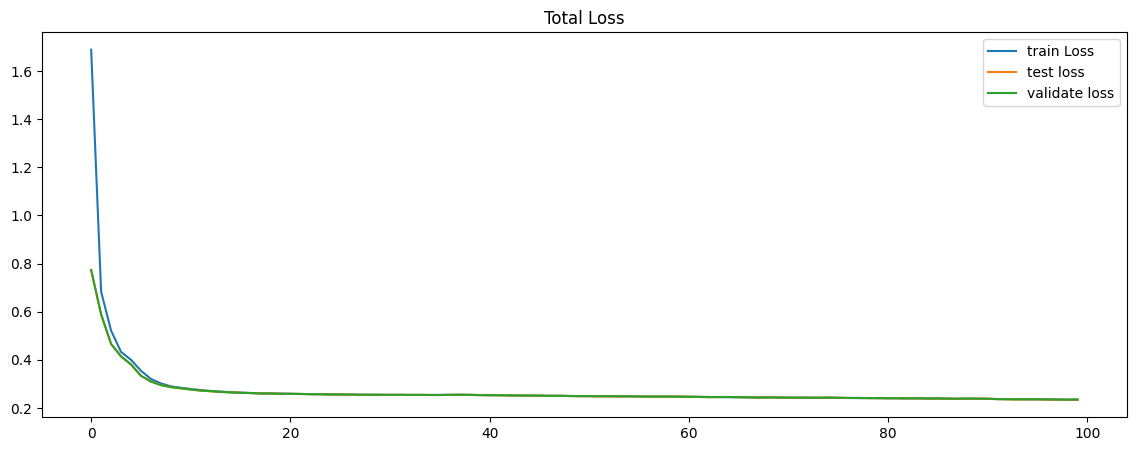

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='train Loss')
plt.plot(test_total_losses, label='test loss')
plt.plot(val_total_losses, label='validate loss')
plt.legend()
plt.title('Total Loss')
plt.show()

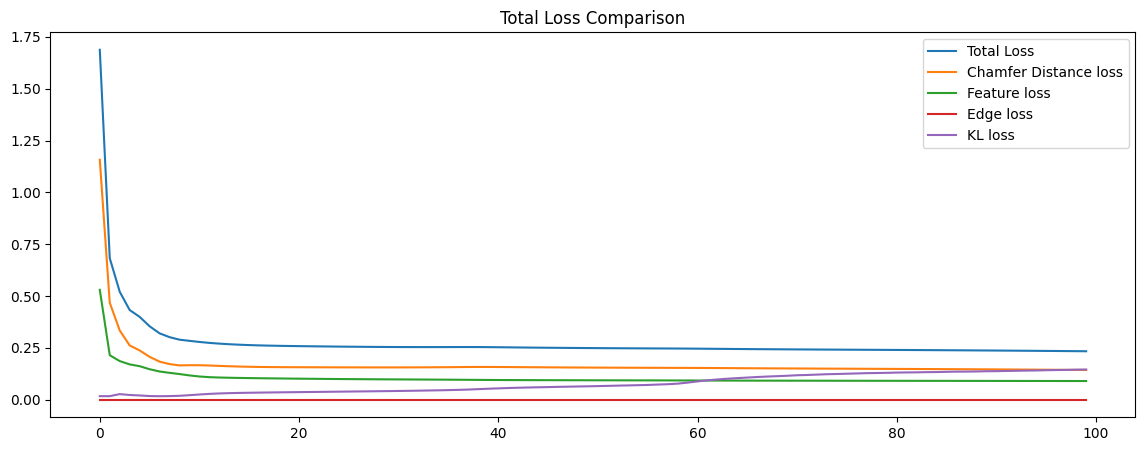

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(feature_losses, label='Feature loss')
plt.plot(edge_losses, label='Edge loss')
plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.title('Total Loss Comparison')
plt.show()

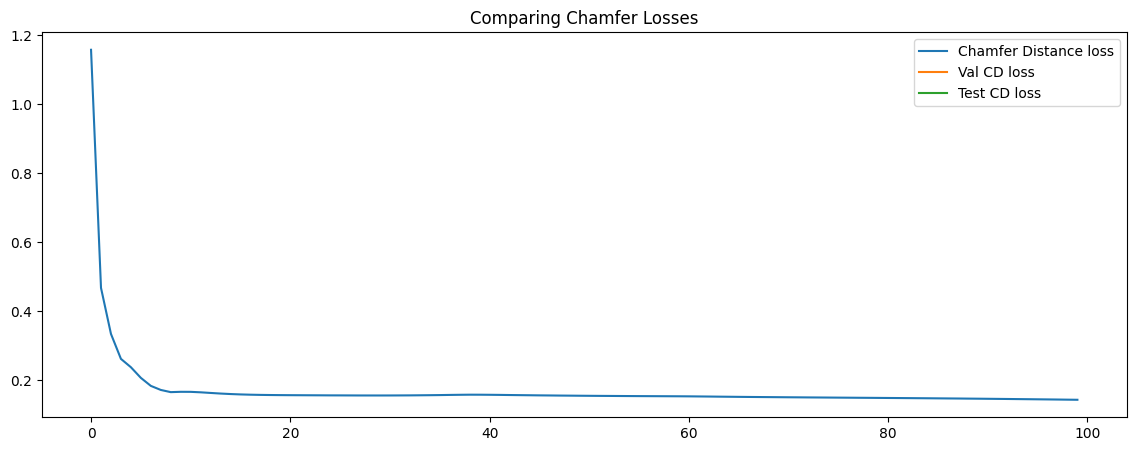

In [24]:
plt.figure(figsize=(14, 5))
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(val_cd_loss, label='Val CD loss')
plt.plot(test_cd_loss, label='Test CD loss')
plt.legend()
plt.title('Comparing Chamfer Losses')
plt.show()

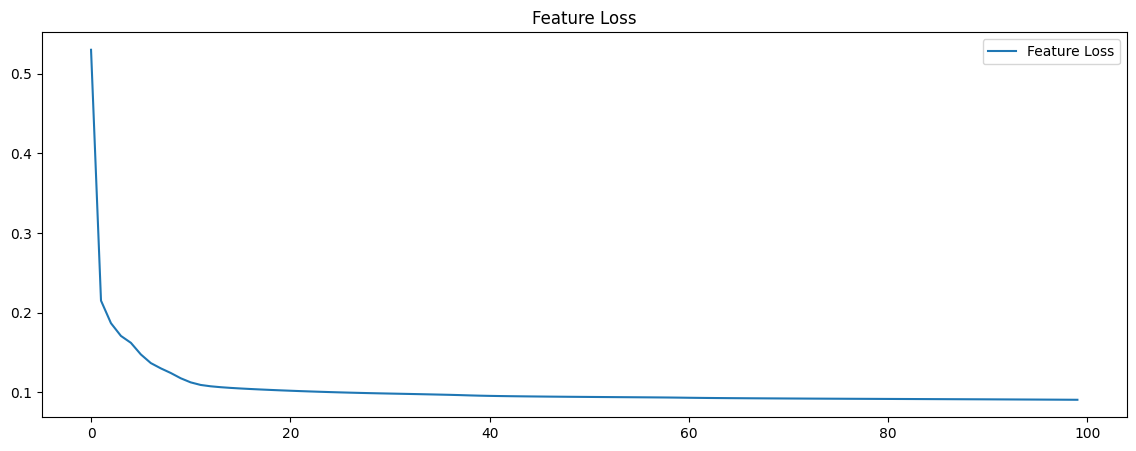

In [25]:

plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()